In [1]:
import pandas as pd
import re
import os
import numpy as np 
import matplotlib.pyplot as plt
import geopandas as gpd
import requests
from shapely.geometry import Point, MultiPolygon
from urllib3.util import Retry
from tenacity import retry, stop_after_attempt, wait_exponential
from shapely.ops import nearest_points
from requests.adapters import HTTPAdapter
from concurrent.futures import ThreadPoolExecutor, as_completed
import folium
import math
import pyproj
from itertools import chain
from pandas.plotting import scatter_matrix 
import seaborn as sns
from sklearn.neighbors import BallTree
from sklearn import set_config
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler, PowerTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.model_selection import cross_val_score 
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from dbfread import DBF
from sklearn.preprocessing import LabelEncoder
from functools import reduce
from scipy.stats import skew


from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from scipy.stats import skew


from sklearn.feature_selection import RFECV

set_config(display='diagram')

# Creating a CSV from the photos

In [2]:
# Path to the folder containing the photos
folder_path = '/Users/joseph/SRC/Maters/New/Jan/new/CheckingImageCollection/AllImagesFeb'  # Replace with your actual folder path

# List all files in the folder
file_list = [file for file in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file))]

# Create a DataFrame
Photos = pd.DataFrame(file_list, columns=['filename'])

In [3]:
def extract_components(filename):
    pattern = r'!?([^_]+)_(\d+)_(\d+)--([-.\d,]+)\.jpg'
    match = re.match(pattern, filename)
    if match:
        return match.groups()
    else:
        return [None, None, None, None]


In [4]:
Photos[['Municipality', 'OSM_ID', 'WARDID', 'CoordinateValue']] = Photos['filename'].apply(lambda x: pd.Series(extract_components(x)))


In [5]:
Photos = Photos.groupby(["WARDID"]).size().reset_index(name="sum")


In [6]:
Photos = Photos.rename(columns={'sum': 'NuPhotos'})


In [7]:
Photos

,WARDID,NuPhotos
0,10101001,50
1,10101002,84
2,10101003,3
3,10101004,16
4,10101005,76
...,...,...
3661,94706035,7
3662,94706036,46
3663,94706037,24
3664,94706038,27


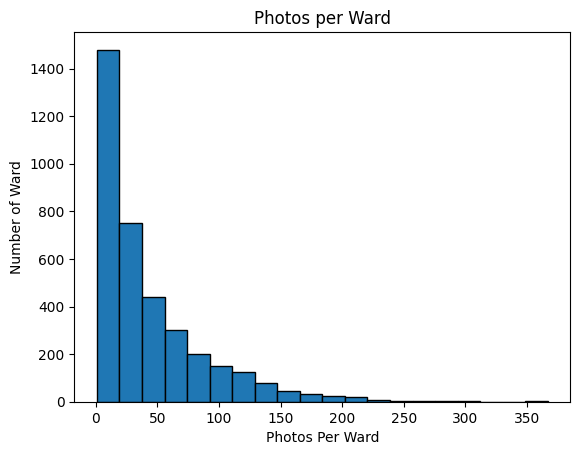

In [8]:

# Plot histogram
plt.hist(Photos['NuPhotos'], bins=20, edgecolor='black')

# Labels and title
plt.xlabel('Photos Per Ward')
plt.ylabel('Number of Ward')
plt.title('Photos per Ward')

# Show plot
plt.show()


# Reading Inference

### ReadingInference For Potholes and People

In [9]:
potholes = pd.read_csv('/Users/joseph/SRC/Maters/New/Feb/CSVCreation/Potholes/InferencePeople.csv')
people = pd.read_csv('/Users/joseph/SRC/Maters/New/Feb/CSVCreation/Potholes/InferencePotholes.csv')
trash = pd.read_csv('/Users/joseph/SRC/Maters/New/Feb/CSVCreation/Potholes/InferenceTrash.csv')
vehicles = pd.read_csv('/Users/joseph/SRC/Maters/New/Feb/CSVCreation/Potholes/InferenceCars.csv')

In [10]:
vehicles['class'].unique()

array([3, 1, 0, 2])

In [11]:
buses = vehicles[vehicles['class'] == 0]
cars = vehicles[vehicles['class'] == 1]
motorbikes = vehicles[vehicles['class'] == 2]
trucks = vehicles[vehicles['class'] == 3]



In [12]:
def extract_components(filename):
    pattern = r'!?([^_]+)_(\d+)_(\d+)--([-.\d,]+)\.jpg'
    match = re.match(pattern, filename)
    if match:
        return match.groups()
    else:
        return [None, None, None, None]


In [13]:
people[['Municipality', 'OSM_ID', 'WARDID', 'CoordinateValue']] = people['filename'].apply(lambda x: pd.Series(extract_components(x)))
potholes[['Municipality', 'OSM_ID', 'WARDID', 'CoordinateValue']] = potholes['filename'].apply(lambda x: pd.Series(extract_components(x)))
trash[['Municipality', 'OSM_ID', 'WARDID', 'CoordinateValue']] = trash['filename'].apply(lambda x: pd.Series(extract_components(x)))
cars[['Municipality', 'OSM_ID', 'WARDID', 'CoordinateValue']] = cars['filename'].apply(lambda x: pd.Series(extract_components(x)))
buses[['Municipality', 'OSM_ID', 'WARDID', 'CoordinateValue']] = buses['filename'].apply(lambda x: pd.Series(extract_components(x)))
motorbikes[['Municipality', 'OSM_ID', 'WARDID', 'CoordinateValue']] = motorbikes['filename'].apply(lambda x: pd.Series(extract_components(x)))
trucks[['Municipality', 'OSM_ID', 'WARDID', 'CoordinateValue']] = trucks['filename'].apply(lambda x: pd.Series(extract_components(x)))




/var/folders/20/l853m0wd02b4mwcklpnsdqx40000gn/T/ipykernel_78415/1410151993.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cars[['Municipality', 'OSM_ID', 'WARDID', 'CoordinateValue']] = cars['filename'].apply(lambda x: pd.Series(extract_components(x)))
/var/folders/20/l853m0wd02b4mwcklpnsdqx40000gn/T/ipykernel_78415/1410151993.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cars[['Municipality', 'OSM_ID', 'WARDID', 'CoordinateValue']] = cars['filename'].apply(lambda x: pd.Series(extract_components

In [14]:
def plot_probability(dataframe, name):
    # Define the confidence intervals (buckets)
    bins = np.arange(0, 1.05, 0.05)  # Intervals: 0-0.05, 0.05-0.1, ..., 0.95-1.0

    # Create a histogram to count Wards in each bucket
    counts, edges = np.histogram(dataframe["confidence"], bins=bins)

    # Plot the bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(
        x=[f"{edges[i]:.1f}-{edges[i+1]:.1f}" for i in range(len(edges) - 1)],  # Bucket labels
        height=counts,  # Counts in each bucket
        color="blue", alpha=0.7
    )

    # Add labels and title
    plt.xlabel("Confidence Interval", fontsize=12)
    plt.ylabel("Number of Photos", fontsize=12)
    plt.title(f"Distribution of {name} by Confidence Intervals", fontsize=14)  # Modified title
    plt.xticks(rotation=45, fontsize=10)

    # Show the plot
    plt.tight_layout()
    plt.show()
    

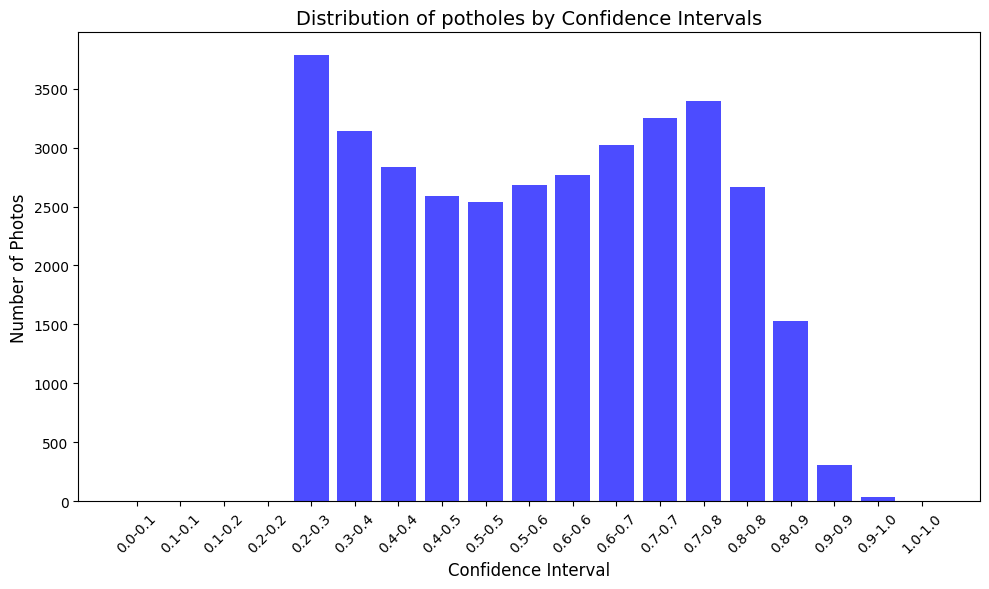

In [15]:
plot_probability(potholes,"potholes")

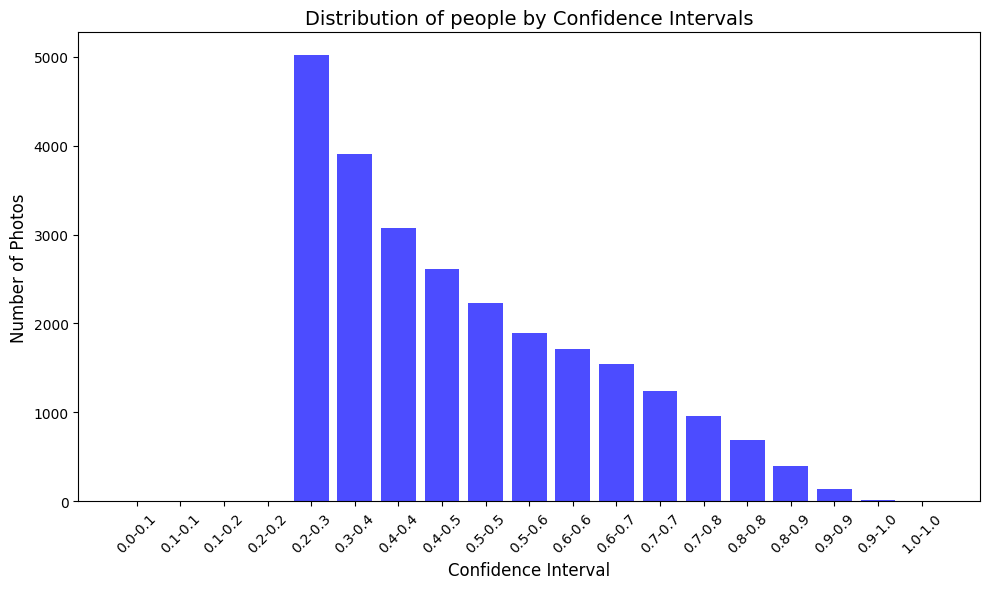

In [16]:
plot_probability(people,"people")

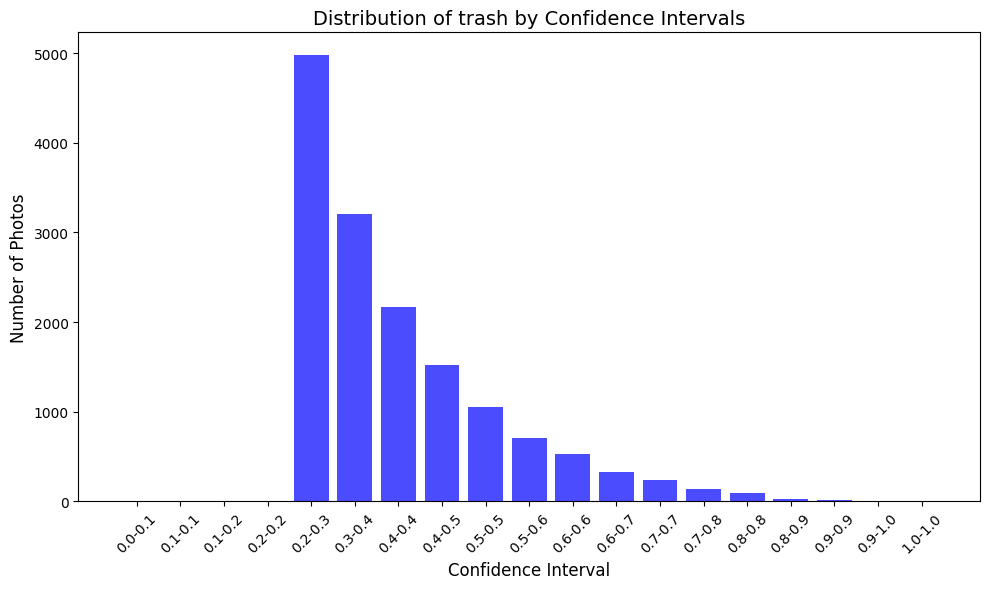

In [17]:
plot_probability(trash,"trash")

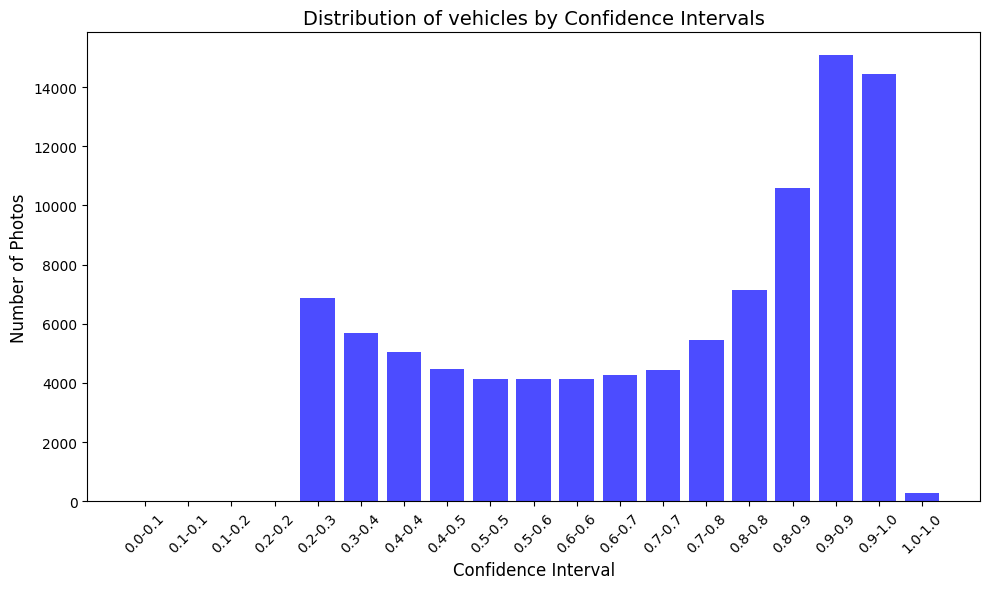

In [18]:
plot_probability(vehicles,"vehicles")

In [19]:
potholes = potholes[potholes['confidence'] > 0.3]
people = people[people['confidence'] > 0.3]
trash = trash[trash['confidence'] > 0.3]
cars = cars[cars['confidence'] > 0.3]

In [20]:
def grouping(df,column_name):
    df = df[['WARDID']]
    df = df.groupby(["WARDID"]).size().reset_index(name="sum")
    df = df.rename(columns={'sum': column_name})
    return df

In [21]:
potholes = grouping(potholes,"Potholes")
people = grouping(people,"People")
trash = grouping(trash,"Trash")
cars = grouping(cars,"Cars")
buses = grouping(buses,"Buses")
motorbikes = grouping(motorbikes,"Motorbikes")
trucks = grouping(trucks,"Trucks")

### Adding in missing wards for Inference

In [22]:
def add_missing_wards(Photos, dataframe, column_name):
    # Identify missing wards
    Wards_not_in_Photos = set(Photos["WARDID"].unique()) - set(dataframe["WARDID"].unique())

    # Create a DataFrame for the missing wards with zero values, except for WardID
    missing_wards_df = pd.DataFrame({
        "WARDID": list(Wards_not_in_Photos),
        column_name: 0,  # Example column
    })

    # Append the missing rows to the original DataFrame
    dataframe = pd.concat([dataframe, missing_wards_df], ignore_index=True)
    return dataframe

In [23]:
potholes = add_missing_wards(Photos, potholes, "Potholes")
people = add_missing_wards(Photos, people, "People")
trash = add_missing_wards(Photos, trash, "Trash")
cars = add_missing_wards(Photos, cars, "Cars")  
buses = add_missing_wards(Photos, buses, "Buses")
motorbikes = add_missing_wards(Photos, motorbikes, "Motorbikes")
trucks = add_missing_wards(Photos, trucks, "Trucks")

In [24]:
# List of dataframes to merge
dfs = [people, potholes, trash, cars, buses,motorbikes,trucks, Photos]

# Merge all DataFrames on 'WARDID'
merged_df = reduce(lambda left, right: pd.merge(left, right, on='WARDID'), dfs)

In [25]:
merged_df.rename(columns={'WARDID': 'WardID'}, inplace=True)
merged_df

,WardID,People,Potholes,Trash,Cars,Buses,Motorbikes,Trucks,NuPhotos
0,10101001,6,7,3,13,0,6,2,50
1,10101002,8,12,4,29,7,4,7,84
2,10101004,3,9,2,2,0,0,0,16
3,10101005,7,6,1,24,2,0,6,76
4,10101006,18,17,1,9,0,1,0,57
...,...,...,...,...,...,...,...,...,...
3661,63702028,0,1,0,0,0,2,0,2
3662,24403029,0,2,0,7,0,0,0,22
3663,63705004,0,1,0,0,0,0,1,11
3664,83205025,0,0,1,2,0,1,0,21


In [26]:
merged_df['PotholeRatio'] = merged_df['Potholes'] / merged_df['NuPhotos']
merged_df['PeopleRatio'] = merged_df['People'] / merged_df['NuPhotos']
merged_df['TrashRatio'] = merged_df['Trash'] / merged_df['NuPhotos']
merged_df['CarRatio'] = merged_df['Cars'] / merged_df['NuPhotos']
merged_df['BusRatio'] = merged_df['Buses'] / merged_df['NuPhotos']
merged_df['TruckRatio'] = merged_df['Trucks'] / merged_df['NuPhotos']   
merged_df['MotorbikeRatio'] = merged_df['Motorbikes'] / merged_df['NuPhotos']
merged_df

,WardID,People,Potholes,Trash,Cars,Buses,Motorbikes,Trucks,NuPhotos,PotholeRatio,PeopleRatio,TrashRatio,CarRatio,BusRatio,TruckRatio,MotorbikeRatio
0,10101001,6,7,3,13,0,6,2,50,0.140000,0.120000,0.060000,0.260000,0.000000,0.040000,0.120000
1,10101002,8,12,4,29,7,4,7,84,0.142857,0.095238,0.047619,0.345238,0.083333,0.083333,0.047619
2,10101004,3,9,2,2,0,0,0,16,0.562500,0.187500,0.125000,0.125000,0.000000,0.000000,0.000000
3,10101005,7,6,1,24,2,0,6,76,0.078947,0.092105,0.013158,0.315789,0.026316,0.078947,0.000000
4,10101006,18,17,1,9,0,1,0,57,0.298246,0.315789,0.017544,0.157895,0.000000,0.000000,0.017544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3661,63702028,0,1,0,0,0,2,0,2,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
3662,24403029,0,2,0,7,0,0,0,22,0.090909,0.000000,0.000000,0.318182,0.000000,0.000000,0.000000
3663,63705004,0,1,0,0,0,0,1,11,0.090909,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000
3664,83205025,0,0,1,2,0,1,0,21,0.000000,0.000000,0.047619,0.095238,0.000000,0.000000,0.047619


# Roads

In [27]:
roads = gpd.read_file('/Users/joseph/SRC/Maters/New/Feb/CSVCreation/Take1/Data/Shapefiles/south-africa-latest-free.shp/gis_osm_roads_free_1.shp')

In [28]:
roads.drop(['code','ref','name','oneway', 'maxspeed','layer','bridge','tunnel'], axis=1, inplace=True)

In [29]:
usefullRoads = roads[roads['fclass'].isin([ 'tertiary','residential','secondary'])]

### Existing Roads

In [30]:
# Read the CSV file into a dataframe
EC = pd.read_csv('/Users/joseph/SRC/Maters/New/Feb/CSVCreation/Take1/Data/Shapefiles/ProvincesStreetViewRoads/Eastern Cape.csv')
FS = pd.read_csv('/Users/joseph/SRC/Maters/New/Feb/CSVCreation/Take1/Data/Shapefiles/ProvincesStreetViewRoads/Free State.csv')
GP = pd.read_csv('/Users/joseph/SRC/Maters/New/Feb/CSVCreation/Take1/Data/Shapefiles/ProvincesStreetViewRoads/Gauteng.csv')
KZN = pd.read_csv('/Users/joseph/SRC/Maters/New/Feb/CSVCreation/Take1/Data/Shapefiles/ProvincesStreetViewRoads/KwaZulu-Natal.csv')
MP = pd.read_csv('/Users/joseph/SRC/Maters/New/Feb/CSVCreation/Take1/Data/Shapefiles/ProvincesStreetViewRoads/Limpopo.csv')
NC = pd.read_csv('/Users/joseph/SRC/Maters/New/Feb/CSVCreation/Take1/Data/Shapefiles/ProvincesStreetViewRoads/Mpumalanga.csv')
NW = pd.read_csv('/Users/joseph/SRC/Maters/New/Feb/CSVCreation/Take1/Data/Shapefiles/ProvincesStreetViewRoads/North West.csv')
WC = pd.read_csv('/Users/joseph/SRC/Maters/New/Feb/CSVCreation/Take1/Data/Shapefiles/ProvincesStreetViewRoads/Northern Cape.csv')
lm = pd.read_csv('/Users/joseph/SRC/Maters/New/Feb/CSVCreation/Take1/Data/Shapefiles/ProvincesStreetViewRoads/Western Cape.csv')


combined_df = pd.concat([EC, FS, GP, KZN, MP, WC, NC, NW,lm])

In [31]:
exists = combined_df[(combined_df['status1'] == 1) & (combined_df['status2'] == 1)]
exists['osm_id'] = exists['osm_id'].astype(str)

/var/folders/20/l853m0wd02b4mwcklpnsdqx40000gn/T/ipykernel_78415/669118614.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exists['osm_id'] = exists['osm_id'].astype(str)


In [32]:
# This is a dataframe of of all the roads that exist
exists.shape

(327154, 15)

In [33]:
usefullRoads['match'] = usefullRoads['osm_id'].isin(exists['osm_id']).astype(int)

/opt/miniconda3/envs/streerview/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [34]:
# This is now a dataframe of all roads and whether they exist or not - we then need to merge this to Ward :)
usefullRoads

,osm_id,fclass,geometry,match
0,3715718,residential,"LINESTRING (25.55753 -33.95111, 25.55891 -33.9...",1
2,3823543,residential,"LINESTRING (25.55782 -33.95025, 25.5579 -33.95...",1
3,3823545,residential,"LINESTRING (25.55837 -33.94864, 25.55829 -33.9...",1
4,3823547,residential,"LINESTRING (25.55968 -33.95414, 25.55974 -33.9...",1
5,3845300,residential,"LINESTRING (25.55725 -33.95197, 25.55914 -33.9...",1
...,...,...,...,...
1877439,1300644672,residential,"LINESTRING (28.19391 -25.9775, 28.1938 -25.977...",0
1877440,1300644673,residential,"LINESTRING (28.19075 -25.97778, 28.1907 -25.97...",0
1877441,1300653750,residential,"LINESTRING (26.18558 -29.05951, 26.18612 -29.0...",0
1877442,1300664869,residential,"LINESTRING (18.732 -34.01397, 18.73217 -34.013...",1


In [35]:
Ward = gpd.read_file('/Users/joseph/SRC/Maters/New/Feb/CSVCreation/Take1/Data/Shapefiles/MBD/MDB_Wards_2020.shp')
Ward = Ward[['WardID','geometry']]



/opt/miniconda3/envs/streerview/lib/python3.12/site-packages/pyogrio/raw.py:196: RuntimeWarning: /Users/joseph/SRC/Maters/New/Feb/CSVCreation/Take1/Data/Shapefiles/MBD/MDB_Wards_2020.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


### Adding Ward To Roads

In [36]:
# Define the target CRS
tgt_crs = 'EPSG:3857'  # GCS_WGS_1984

# Transform the CRS of the entire GeoDataFrame
Ward = Ward.to_crs(tgt_crs)
usefullRoads = usefullRoads.to_crs(tgt_crs)

In [37]:
WardRoads = gpd.sjoin(usefullRoads, Ward, how='left', predicate='within')

In [38]:
WardRoads.drop(['index_right'], axis=1, inplace=True)


In [39]:
WardRoads.dropna(inplace=True)

### Getting the missing roads

In [40]:
missingRoads = usefullRoads[~usefullRoads['osm_id'].isin(WardRoads['osm_id'])]

In [41]:
# Perform a spatial join that allows multiple matches (each LineString might intersect multiple geometries)
missingMergedRoads = gpd.sjoin(missingRoads, Ward, how='left', predicate='intersects')

# Calculate the length of each intersection between the LineString and the geometry
missingMergedRoads['intersection_length'] = missingMergedRoads.apply(lambda row: row.geometry.intersection(row['geometry']).length, axis=1)

# Sort by osm_id and intersection_length in descending order to have the largest intersection first
missingMergedRoads = missingMergedRoads.sort_values(by=['osm_id', 'intersection_length'], ascending=[True, False])

# Drop duplicates, keeping only the first occurrence (which has the largest intersection)
missingMergedRoads = missingMergedRoads.drop_duplicates(subset='osm_id', keep='first')

In [42]:
missingMergedRoads.drop(['index_right'], axis=1, inplace=True)
# Specify the desired column order
column_order = ['osm_id', 'fclass','geometry', 'match','WardID']

# Reindex the dataframe with the desired column order
missingMergedRoads = missingMergedRoads.reindex(columns=column_order)

In [43]:
missingMergedRoads.dropna(inplace=True)

In [44]:
WardRoads = pd.concat([WardRoads, missingMergedRoads], axis=0)

In [45]:
Temp = WardRoads.copy()

In [46]:
Temp['Exist'] = Temp['match']
Temp['DNExist'] = 1 - Temp['match']

In [47]:
Temp.drop(['match','osm_id', 'fclass', 'geometry'], axis=1, inplace=True)


In [48]:
GroupedRoads = Temp.groupby("WardID")[["Exist", "DNExist"]].sum().reset_index()


In [49]:
GroupedRoads

,WardID,Exist,DNExist
0,10101001,15,160
1,10101002,34,146
2,10101003,2,99
3,10101004,5,73
4,10101005,21,128
...,...,...,...
4459,94706035,3,225
4460,94706036,15,372
4461,94706037,12,259
4462,94706038,12,429


### Adding Merged_Df

In [50]:
merged_df = pd.merge(GroupedRoads, merged_df, on='WardID')

In [51]:
merged_df['NuRoads']=merged_df['Exist']+merged_df['DNExist']
merged_df['RoadRatio'] = merged_df['Exist'] / merged_df['NuRoads']
merged_df.loc[merged_df['DNExist'] == 0, 'RoadRatio'] = 1  #### what about if there are no roads...
merged_df

,WardID,Exist,DNExist,People,Potholes,Trash,Cars,Buses,Motorbikes,Trucks,NuPhotos,PotholeRatio,PeopleRatio,TrashRatio,CarRatio,BusRatio,TruckRatio,MotorbikeRatio,NuRoads,RoadRatio
0,10101001,15,160,6,7,3,13,0,6,2,50,0.140000,0.120000,0.060000,0.260000,0.000000,0.040000,0.120000,175,0.085714
1,10101002,34,146,8,12,4,29,7,4,7,84,0.142857,0.095238,0.047619,0.345238,0.083333,0.083333,0.047619,180,0.188889
2,10101003,2,99,0,0,0,1,0,0,0,3,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,101,0.019802
3,10101004,5,73,3,9,2,2,0,0,0,16,0.562500,0.187500,0.125000,0.125000,0.000000,0.000000,0.000000,78,0.064103
4,10101005,21,128,7,6,1,24,2,0,6,76,0.078947,0.092105,0.013158,0.315789,0.026316,0.078947,0.000000,149,0.140940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3661,94706035,3,225,0,0,0,1,0,0,0,7,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,228,0.013158
3662,94706036,15,372,4,4,1,12,0,1,1,46,0.086957,0.086957,0.021739,0.260870,0.000000,0.021739,0.021739,387,0.038760
3663,94706037,12,259,1,13,0,4,0,4,0,24,0.541667,0.041667,0.000000,0.166667,0.000000,0.000000,0.166667,271,0.044280
3664,94706038,12,429,1,5,2,7,0,0,1,27,0.185185,0.037037,0.074074,0.259259,0.000000,0.037037,0.000000,441,0.027211


# Getting Wards

In [52]:
Ward = gpd.read_file('/Users/joseph/SRC/Maters/New/Feb/CSVCreation/Take1/Data/Shapefiles/MBD/MDB_Wards_2020.shp')
Ward = Ward[['WardID','geometry']]

/opt/miniconda3/envs/streerview/lib/python3.12/site-packages/pyogrio/raw.py:196: RuntimeWarning: /Users/joseph/SRC/Maters/New/Feb/CSVCreation/Take1/Data/Shapefiles/MBD/MDB_Wards_2020.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


In [53]:
merged_ward = pd.merge(Ward, merged_df, on='WardID')


In [54]:
merged_ward

,WardID,geometry,Exist,DNExist,People,Potholes,Trash,Cars,Buses,Motorbikes,...,NuPhotos,PotholeRatio,PeopleRatio,TrashRatio,CarRatio,BusRatio,TruckRatio,MotorbikeRatio,NuRoads,RoadRatio
0,10503001,"POLYGON ((2642111.341 -3718052.495, 2639959.53...",49,96,4,24,5,15,0,6,...,62,0.387097,0.064516,0.080645,0.241935,0.000000,0.016129,0.096774,145,0.337931
1,10503002,"POLYGON ((2530859.756 -3737004.848, 2527499.02...",124,159,23,6,6,53,2,4,...,174,0.034483,0.132184,0.034483,0.304598,0.011494,0.017241,0.022989,283,0.438163
2,10503003,"POLYGON ((2511824.551 -3811376.089, 2511830.80...",35,63,6,17,6,14,0,0,...,62,0.274194,0.096774,0.096774,0.225806,0.000000,0.016129,0.000000,98,0.357143
3,10503004,"POLYGON ((2514892.533 -3809283.124, 2514712.64...",54,71,6,14,3,24,0,3,...,98,0.142857,0.061224,0.030612,0.244898,0.000000,0.010204,0.030612,125,0.432000
4,10503005,"POLYGON ((2513764.194 -3810332.85, 2513748.528...",50,24,17,31,5,35,0,6,...,80,0.387500,0.212500,0.062500,0.437500,0.000000,0.012500,0.075000,74,0.675676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3661,34501007,"POLYGON ((2629776.251 -3126583.144, 2627893.95...",2,190,2,0,2,0,0,0,...,11,0.000000,0.181818,0.181818,0.000000,0.000000,0.000000,0.000000,192,0.010417
3662,34501008,"POLYGON ((2645034.591 -3103615.815, 2645031.25...",2,84,0,0,0,0,0,1,...,6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,86,0.023256
3663,34501013,"POLYGON ((2636306.92 -3132397.447, 2636038.974...",2,136,0,0,0,0,0,0,...,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,138,0.014493
3664,34501014,"POLYGON ((2640857.55 -3145315.587, 2641882.022...",2,209,0,1,1,4,0,0,...,13,0.076923,0.000000,0.076923,0.307692,0.000000,0.076923,0.000000,211,0.009479


# Getting LandUse

This takes 3:04 mins

In [55]:
landUse = gpd.read_file('/Users/joseph/SRC/Maters/New/Feb/CSVCreation/Take1/Data/Vector4/Final.shp')
landUse = landUse[landUse['DN'] != 0]
landUse = landUse.sort_values('DN', ascending=True)

In [56]:
# Open the .dbf file
dbf_path = "/Users/joseph/SRC/Maters/New/Feb/CSVCreation/Take1/Data/SA_NLC_2022_GEO.tif/SA_NLC_2022_GEO.tif.vat.dbf"
table = DBF(dbf_path)


In [57]:
# Convert DBF to a pandas DataFrame for easier manipulation
df = pd.DataFrame(iter(table))
df = df[df['Count'] != 0]
df = df[df['Value'] != 0]
df = df.drop('Count', axis=1)

In [58]:
landUse = pd.merge(landUse, df, left_on='DN', right_on='Value')


In [59]:
# Define the target CRS
tgt_crs = 'EPSG:3857'  # GCS_WGS_1984

# Transform the CRS of the entire GeoDataFrame
landUse = landUse.to_crs(tgt_crs)


In [60]:
tempWard = Ward.copy()

In [61]:
def create_pivot(Ward, landUse, column_name):
    Ward['Place_Area'] = Ward['geometry'].area
    landUseMerged = gpd.sjoin(landUse, Ward, how='left', predicate='within')
    landUseMerged = landUseMerged[['WardID','geometry',column_name,'Place_Area']]
    landUseMerged= landUseMerged.dropna()
    landUseMerged['Polygon_Area'] = landUseMerged['geometry'].area
    landUseMerged['Percentage_Area'] = landUseMerged['Polygon_Area']/landUseMerged['Place_Area'] * 100
    landUseMerged = landUseMerged.groupby(['WardID',column_name])[['Percentage_Area']].sum().reset_index()
    landUseMerged = landUseMerged.pivot_table(index=['WardID'],
                                columns=column_name, 
                                values='Percentage_Area',
                                fill_value=0).reset_index()
    return landUseMerged



In [62]:
landUseMergedClass = create_pivot(Ward, landUse, 'Class_Name')
landUseMergedSALCC_1 = create_pivot(Ward, landUse, 'SALCC_1')
landUseMergedSALCC_2 = create_pivot(Ward, landUse, 'SALCC_2')

In [63]:
LandUseMerged = pd.merge(landUseMergedClass, landUseMergedSALCC_1, on='WardID', how='right')
LandUseMerged = pd.merge(LandUseMerged, landUseMergedSALCC_2, on='WardID', how='right')

In [64]:
LandUseMerged

,WardID,artificial dams (including canals),artificial flooded mine pits,artificial sewage ponds,bare riverbed material,coastal sand & dunes,commercial,commercial annual crops non-pivot irrigated,commercial annual crops pivot irrigated,commercial annual crops rain-fed / dryland,...,Shrubs,Smallholdings,Surface Infrastructure,Temporary Crops,Transport,Unconsolidated,Urban Vegetation,Village,Waste & Resource Dumps,Woody Wetlands
0,10101001,0.151608,0.084205,0.016838,0.404193,0.000000,0.185239,0.606294,0.134808,2.981563,...,6.854440,0.000000,0.000000,3.722665,0.421088,3.705196,0.050523,0.336893,0.0,0.0
1,10101002,0.029023,0.000000,0.000000,0.058085,0.029062,0.050793,0.101510,0.610216,3.056300,...,0.007255,0.058051,0.000000,3.768026,0.261335,0.718288,0.007256,0.108828,0.0,0.0
2,10101003,0.017554,0.000000,0.000000,0.894048,0.000000,0.000000,0.070212,0.000000,0.491424,...,9.188090,0.000000,0.000000,0.561636,0.210551,9.852162,0.000000,0.122851,0.0,0.0
3,10101004,0.242240,0.000000,0.000000,0.000000,0.000000,0.403598,0.000000,0.000000,0.888164,...,2.341275,0.000000,0.646012,0.888164,0.403680,4.359539,0.887994,1.049560,0.0,0.0
4,10101005,0.029857,0.000000,0.000000,0.009953,0.059821,0.000000,0.034830,0.532710,7.277079,...,0.233784,0.000000,0.000000,7.844619,0.234133,1.135390,0.034830,0.179132,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4424,94706035,0.000000,0.000000,0.000000,0.024850,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,5.315205,0.074495,9.016558,0.000000,0.571380,0.0,0.0
4425,94706036,0.000000,0.000000,0.000000,0.208786,0.000000,0.208792,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,3.132324,0.104411,8.143839,0.000000,6.055667,0.0,0.0
4426,94706037,0.000000,0.000000,0.000000,0.282815,0.000000,0.000000,0.000000,0.423982,0.188429,...,0.000000,0.000000,0.000000,2.945062,0.188497,2.615032,0.000000,1.060497,0.0,0.0
4427,94706038,0.000000,0.000000,0.000000,0.025298,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,10.396835,0.151785,5.589501,0.000000,1.112934,0.0,0.0


Cool so we see that there are no missing values. The issue comes when you divide by zero

In [65]:
df_with_null = LandUseMerged[LandUseMerged.isnull().any(axis=1)]
df_with_null

,WardID,artificial dams (including canals),artificial flooded mine pits,artificial sewage ponds,bare riverbed material,coastal sand & dunes,commercial,commercial annual crops non-pivot irrigated,commercial annual crops pivot irrigated,commercial annual crops rain-fed / dryland,...,Shrubs,Smallholdings,Surface Infrastructure,Temporary Crops,Transport,Unconsolidated,Urban Vegetation,Village,Waste & Resource Dumps,Woody Wetlands


In [66]:
merged_ward = pd.merge(merged_ward, LandUseMerged, on='WardID')

In [67]:
df_with_null = merged_ward[merged_ward.isnull().any(axis=1)]
df_with_null

,WardID,geometry,Exist,DNExist,People,Potholes,Trash,Cars,Buses,Motorbikes,...,Shrubs,Smallholdings,Surface Infrastructure,Temporary Crops,Transport,Unconsolidated,Urban Vegetation,Village,Waste & Resource Dumps,Woody Wetlands


In [68]:
merged_ward

,WardID,geometry,Exist,DNExist,People,Potholes,Trash,Cars,Buses,Motorbikes,...,Shrubs,Smallholdings,Surface Infrastructure,Temporary Crops,Transport,Unconsolidated,Urban Vegetation,Village,Waste & Resource Dumps,Woody Wetlands
0,10503001,"POLYGON ((2642111.341 -3718052.495, 2639959.53...",49,96,4,24,5,15,0,6,...,2.963961,0.0,0.0,0.745209,0.046170,1.082680,0.000000,0.024681,0.0,0.0
1,10503002,"POLYGON ((2530859.756 -3737004.848, 2527499.02...",124,159,23,6,6,53,2,4,...,5.779832,0.0,0.0,0.340218,0.118102,10.019574,0.000814,0.024812,0.0,0.0
2,10503003,"POLYGON ((2511824.551 -3811376.089, 2511830.80...",35,63,6,17,6,14,0,0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
3,10503004,"POLYGON ((2514892.533 -3809283.124, 2514712.64...",54,71,6,14,3,24,0,3,...,17.591718,0.0,0.0,0.000000,0.000000,9.819113,0.818250,1.227200,0.0,0.0
4,10503005,"POLYGON ((2513764.194 -3810332.85, 2513748.528...",50,24,17,31,5,35,0,6,...,3.038415,0.0,0.0,0.000000,0.000000,0.000000,1.519253,1.519162,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3631,34501007,"POLYGON ((2629776.251 -3126583.144, 2627893.95...",2,190,2,0,2,0,0,0,...,0.270321,0.0,0.0,0.000000,0.180157,0.072971,0.000000,0.077232,0.0,0.0
3632,34501008,"POLYGON ((2645034.591 -3103615.815, 2645031.25...",2,84,0,0,0,0,0,1,...,0.091022,0.0,0.0,0.000000,0.189979,0.110806,0.000000,0.047499,0.0,0.0
3633,34501013,"POLYGON ((2636306.92 -3132397.447, 2636038.974...",2,136,0,0,0,0,0,0,...,0.114705,0.0,0.0,0.000000,0.088664,0.020868,0.000000,0.125139,0.0,0.0
3634,34501014,"POLYGON ((2640857.55 -3145315.587, 2641882.022...",2,209,0,1,1,4,0,0,...,0.140143,0.0,0.0,0.000000,0.235454,0.403698,0.000000,0.089708,0.0,0.0


# Adding IEC Results

### Creating Linking

In [69]:
EC = pd.read_csv('/Users/joseph/SRC/Maters/New/Feb/CSVCreation/Take1/IECData/Provinces/EC.csv')
FS = pd.read_csv('/Users/joseph/SRC/Maters/New/Feb/CSVCreation/Take1/IECData/Provinces/FS.csv')
GP = pd.read_csv('/Users/joseph/SRC/Maters/New/Feb/CSVCreation/Take1/IECData/Provinces/GP.csv')
KZN = pd.read_csv('/Users/joseph/SRC/Maters/New/Feb/CSVCreation/Take1/IECData/Provinces/KN.csv')
MP = pd.read_csv('/Users/joseph/SRC/Maters/New/Feb/CSVCreation/Take1/IECData/Provinces/MP.csv')
NC = pd.read_csv('/Users/joseph/SRC/Maters/New/Feb/CSVCreation/Take1/IECData/Provinces/NC.csv')
NW = pd.read_csv('/Users/joseph/SRC/Maters/New/Feb/CSVCreation/Take1/IECData/Provinces/NP.csv')
LM = pd.read_csv('/Users/joseph/SRC/Maters/New/Feb/CSVCreation/Take1/IECData/Provinces/NW.csv')
WC = pd.read_csv('/Users/joseph/SRC/Maters/New/Feb/CSVCreation/Take1/IECData/Provinces/WP.csv')
Local = pd.concat([EC, FS, GP, KZN, MP, NC, NW, LM, WC])

# Rename the 'Ward' column to 'Ward ID'
Local.rename(columns={'Ward': 'WardID'}, inplace=True)

# Remove the word "Ward" from the 'Ward ID' column
# Local['WardID'] = Local['WardID'].str.replace('Ward', '', regex=False)
Local['WardID'] = Local['WardID'].str.replace('Ward ', '', regex=False).astype(str)

In [70]:
National = pd.read_csv('/Users/joseph/SRC/Maters/New/Feb/CSVCreation/Take1/IECData/National.csv')
National.rename(columns={'VD_Number': 'VotingDistrict'}, inplace=True)
National['VotingDistrict'] = National['VotingDistrict'].astype(str)

In [71]:
Linking = Local[['WardID','VotingDistrict']]
Linking = Linking.drop_duplicates()

National['VotingDistrict'] = National['VotingDistrict'].astype(str)
Linking['VotingDistrict'] = Linking['VotingDistrict'].astype(str)

In [72]:
National = pd.merge(National, Linking, on='VotingDistrict', how='left')
National = National.dropna()

In [73]:
National['Municipality'] = National['Municipality'].str.split('- ', n=1).str[1]
National['Municipality'] = National['Municipality'].str.replace('.', '')

In [74]:
National.loc[National['Municipality'] == 'kagisano-molopo', 'Municipality'] = 'ganyesapomfret'
National.loc[National['Municipality'] == 'dr ab xuma', 'Municipality'] = 'engcobo'
National.loc[National['Municipality'] == 'KHâI-MA', 'Municipality'] = 'khaima'
National.loc[National['Municipality'] == '!KHEIS', 'Municipality'] = 'kheis'


In [75]:
# Update the Municipality column for the Eastern Cape province
National.loc[(National['Province'] == 'Eastern Cape') & (National['Municipality'].str.contains('emalahleni', case=False)), 'Municipality'] = 'emalaheleniec'

# Update the Municipality column for the Mpumalanga province
National.loc[(National['Province'] == 'Mpumalanga') & (National['Municipality'].str.contains('emalahleni', case=False)), 'Municipality'] = 'emalahelenimp'


In [76]:
party_votes_summary = National.groupby('sPartyName')['Party_Votes'].sum().reset_index()
party_votes_summary_sorted = party_votes_summary.sort_values(by='Party_Votes', ascending=False).reset_index(drop=True)
party_votes_summary_sorted['Percentage'] = party_votes_summary_sorted['Party_Votes']/party_votes_summary_sorted['Party_Votes'].sum()*100
party_votes_summary_sorted

,sPartyName,Party_Votes,Percentage
0,AFRICAN NATIONAL CONGRESS,6415161,40.242449
1,DEMOCRATIC ALLIANCE,3462124,21.717981
2,UMKHONTO WESIZWE,2326611,14.594883
3,ECONOMIC FREEDOM FIGHTERS,1517813,9.521275
4,INKATHA FREEDOM PARTY,613390,3.847809
5,PATRIOTIC ALLIANCE,329415,2.066428
6,VRYHEIDSFRONT PLUS,217332,1.363329
7,ACTIONSA,190404,1.194409
8,AFRICAN CHRISTIAN DEMOCRATIC PARTY,95806,0.600993
9,UNITED DEMOCRATIC MOVEMENT,77585,0.486692


## Grouping IEC

In [77]:
# Getting the Party Percentage
National['ANC'] = National.apply(lambda row: row['Party_Votes'] if row['sPartyName'] == 'AFRICAN NATIONAL CONGRESS' else 0, axis=1)
National['DA'] = National.apply(lambda row: row['Party_Votes'] if row['sPartyName'] == 'DEMOCRATIC ALLIANCE' else 0, axis=1)
National['MK'] = National.apply(lambda row: row['Party_Votes'] if row['sPartyName'] == 'UMKHONTO WESIZWE ' else 0, axis=1)
National['EFF'] = National.apply(lambda row: row['Party_Votes'] if row['sPartyName'] == 'ECONOMIC FREEDOM FIGHTERS' else 0, axis=1)



# Create the 'Remaining_Parties' column: Assign Party_Votes to 'Remaining_Parties' if not one of the top four parties
National['Remaining_Parties'] = National.apply(
    lambda row: row['Party_Votes'] if row['sPartyName'] not in ['AFRICAN NATIONAL CONGRESS', 'DEMOCRATIC ALLIANCE', 'UMKHONTO WESIZWE ', 'ECONOMIC FREEDOM FIGHTERS'] else 0,
    axis=1
)

# National['IFP'] = National.apply(lambda row: row['Party_Votes'] if row['sPartyName'] == 'INKATHA FREEDOM PARTY' else 0, axis=1)
National = National.drop('sPartyName', axis=1)

In [78]:
National = National.groupby(['Province','Municipality','WardID','Registered_Population','Spoilt_Votes'])[['Party_Votes','ANC','DA','MK','EFF','Remaining_Parties']].sum().reset_index()

In [79]:
National = National.groupby(['Province','Municipality','WardID'])[['Registered_Population','Spoilt_Votes','Party_Votes','ANC','DA','MK','EFF','Remaining_Parties']].sum().reset_index()

In [80]:
National.rename(columns={'Registered_Population': 'RegisteredVoters', 'Spoilt_Votes': 'SpoiltVotes', 'Party_Votes': 'TotalValidVotes'}, inplace=True)


# Combining IEC and Results

In [81]:
Testmerged_ward = pd.merge(merged_ward, National, on='WardID')


# Adding in Labels and further features

In [82]:
merged = Testmerged_ward.copy()

In [83]:
merged

,WardID,geometry,Exist,DNExist,People,Potholes,Trash,Cars,Buses,Motorbikes,...,Province,Municipality,RegisteredVoters,SpoiltVotes,TotalValidVotes,ANC,DA,MK,EFF,Remaining_Parties
0,10503001,"POLYGON ((2642111.341 -3718052.495, 2639959.53...",49,96,4,24,5,15,0,6,...,Western Cape,Beaufort West,3741,31,2021,841,750,5,50,375
1,10503002,"POLYGON ((2530859.756 -3737004.848, 2527499.02...",124,159,23,6,6,53,2,4,...,Western Cape,Beaufort West,3663,16,2204,251,1348,6,22,577
2,10503003,"POLYGON ((2511824.551 -3811376.089, 2511830.80...",35,63,6,17,6,14,0,0,...,Western Cape,Beaufort West,4540,49,2202,485,1004,17,22,674
3,10503004,"POLYGON ((2514892.533 -3809283.124, 2514712.64...",54,71,6,14,3,24,0,3,...,Western Cape,Beaufort West,3811,29,2187,917,643,48,133,446
4,10503005,"POLYGON ((2513764.194 -3810332.85, 2513748.528...",50,24,17,31,5,35,0,6,...,Western Cape,Beaufort West,3481,33,1923,770,639,40,75,399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3631,34501007,"POLYGON ((2629776.251 -3126583.144, 2627893.95...",2,190,2,0,2,0,0,0,...,Northern Cape,Joe Morolong,3815,39,2235,1303,45,6,843,38
3632,34501008,"POLYGON ((2645034.591 -3103615.815, 2645031.25...",2,84,0,0,0,0,0,1,...,Northern Cape,Joe Morolong,3088,29,1754,1059,21,5,648,21
3633,34501013,"POLYGON ((2636306.92 -3132397.447, 2636038.974...",2,136,0,0,0,0,0,0,...,Northern Cape,Joe Morolong,3668,47,1967,1587,17,12,290,61
3634,34501014,"POLYGON ((2640857.55 -3145315.587, 2641882.022...",2,209,0,1,1,4,0,0,...,Northern Cape,Joe Morolong,3791,44,2148,1542,92,14,439,61


### Labels  

In [84]:
# Non Vote percentage Registered
merged['Non Vote (Registered)'] = merged['RegisteredVoters'] - merged['TotalValidVotes'] - merged['SpoiltVotes']
merged['Non Vote Percentage (Registered)'] = merged['Non Vote (Registered)'] / merged['RegisteredVoters'] * 100


# Vote percentage Registered
merged['Vote Percentage (Registered)'] = (merged['TotalValidVotes'] + merged['SpoiltVotes'])/ merged['RegisteredVoters'] * 100


# Party percentage
merged['ANC%'] = merged['ANC']/merged['TotalValidVotes'] * 100
merged['DA%'] = merged['DA']/merged['TotalValidVotes'] * 100
merged['EFF%'] = merged['EFF']/merged['TotalValidVotes'] * 100
merged['MK%'] = merged['MK']/merged['TotalValidVotes'] * 100
merged['Remaining%'] = merged['Remaining_Parties']/merged['TotalValidVotes'] * 100


### Features

### Computing Lag

In [85]:
# # Function to compute spatial lag
# def calculate_spatial_lag(gdf, row, col_name):
#     neighbors = row['neighbors']
#     if not neighbors:  # If no neighbors, return NaN
#         return np.nan
#     return gdf.loc[neighbors, col_name].mean()  # Mean of neighbors' values



In [86]:
# # Calculating Potholag and PeopleLag
# merged['PotholeLag'] = merged.apply(lambda row: calculate_spatial_lag(merged, row, 'PotholeRatio'), axis=1)
# merged['PotholeLagDifference'] = merged['PotholeRatio'] - merged['PotholeLag']

# merged['PeopleLag'] = merged.apply(lambda row: calculate_spatial_lag(merged, row, 'PeopleRatio'), axis=1)
# merged['PeopleLagDifference'] = merged['PeopleRatio'] - merged['PeopleLag']


### Using KNN

In [87]:


# Convert geometry centroids to a NumPy array
merged['centroid'] = merged.geometry.centroid
coords = np.array([(point.x, point.y) for point in merged.centroid])

# Build a BallTree for fast spatial queries
tree = BallTree(coords, leaf_size=2)

# Get indices of 3 nearest neighbors for each area
k = 3
_, indices = tree.query(coords, k=k+1)  # k+1 because first neighbor is itself

# Compute the mean potholes of the nearest neighbors
merged['PotholeLag'] = [merged.iloc[idx[1:], :]['PotholeRatio'].mean() for idx in indices]  # Exclude itself
merged['PeopleLag'] = [merged.iloc[idx[1:], :]['PeopleRatio'].mean() for idx in indices]  # Exclude itself
merged['TrashLag'] = [merged.iloc[idx[1:], :]['TrashRatio'].mean() for idx in indices]  # Exclude itself
merged['CarLag'] = [merged.iloc[idx[1:], :]['CarRatio'].mean() for idx in indices]  # Exclude itself
merged['BusLag'] = [merged.iloc[idx[1:], :]['BusRatio'].mean() for idx in indices]  # Exclude itself
merged['TruckLag'] = [merged.iloc[idx[1:], :]['TruckRatio'].mean() for idx in indices]  # Exclude itself
merged['MotorbikeLag'] = [merged.iloc[idx[1:], :]['MotorbikeRatio'].mean() for idx in indices]  # Exclude itself
merged['RoadLag'] = [merged.iloc[idx[1:], :]['RoadRatio'].mean() for idx in indices]  # Exclude itself


merged['PotholeLagDifference'] = merged['PotholeRatio'] - merged['PotholeLag']
merged['PeopleLagDifference'] = merged['PeopleRatio'] - merged['PeopleLag']
merged['TrashLagDifference'] = merged['TrashRatio'] - merged['TrashLag']
merged['CarLagDifference'] = merged['CarRatio'] - merged['CarLag']
merged['BusLagDifference'] = merged['BusRatio'] - merged['BusLag']
merged['TrucklagDifference'] = merged['TruckRatio'] - merged['TruckLag']
merged['MotorbikeLagDifference'] = merged['MotorbikeRatio'] - merged['MotorbikeLag']
merged['RoadLagDifffference'] = merged['RoadRatio'] - merged['RoadLag']



In [88]:
merged.info()   

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3636 entries, 0 to 3635
Columns: 163 entries, WardID to RoadLagDifffference
dtypes: float64(138), geometry(2), int64(20), object(3)
memory usage: 4.5+ MB


In [89]:
merged

,WardID,geometry,Exist,DNExist,People,Potholes,Trash,Cars,Buses,Motorbikes,...,MotorbikeLag,RoadLag,PotholeLagDifference,PeopleLagDifference,TrashLagDifference,CarLagDifference,BusLagDifference,TrucklagDifference,MotorbikeLagDifference,RoadLagDifffference
0,10503001,"POLYGON ((2642111.341 -3718052.495, 2639959.53...",49,96,4,24,5,15,0,6,...,0.177249,0.113075,0.130483,-0.158909,-0.157210,0.179886,-0.005291,0.005547,-0.080474,0.224856
1,10503002,"POLYGON ((2530859.756 -3737004.848, 2527499.02...",124,159,23,6,6,53,2,4,...,0.035204,0.488273,-0.233701,0.008684,-0.028813,0.001863,0.011494,0.004297,-0.012216,-0.050110
2,10503003,"POLYGON ((2511824.551 -3811376.089, 2511830.80...",35,63,6,17,6,14,0,0,...,0.035204,0.425300,-0.078031,-0.012011,0.048193,-0.054291,0.000000,-0.008983,-0.035204,-0.068157
3,10503004,"POLYGON ((2514892.533 -3809283.124, 2514712.64...",54,71,6,14,3,24,0,3,...,0.025000,0.400348,-0.253146,-0.059411,-0.040023,-0.028836,0.000000,-0.016883,0.005612,0.031652
4,10503005,"POLYGON ((2513764.194 -3810332.85, 2513748.528...",50,24,17,31,5,35,0,6,...,0.010204,0.319122,0.073045,0.142290,0.002494,0.227967,0.000000,-0.013822,0.064796,0.356553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3631,34501007,"POLYGON ((2629776.251 -3126583.144, 2627893.95...",2,190,2,0,2,0,0,0,...,0.027778,0.113291,-0.141636,0.082917,-0.027278,-0.216117,0.000000,-0.011905,-0.027778,-0.102874
3632,34501008,"POLYGON ((2645034.591 -3103615.815, 2645031.25...",2,84,0,0,0,0,0,1,...,0.019592,0.030785,-0.012346,-0.133875,-0.060606,0.000000,0.000000,0.000000,0.147075,-0.007530
3633,34501013,"POLYGON ((2636306.92 -3132397.447, 2636038.974...",2,136,0,0,0,0,0,0,...,0.000000,0.017638,-0.025641,-0.090909,-0.086247,-0.102564,0.000000,-0.025641,0.000000,-0.003145
3634,34501014,"POLYGON ((2640857.55 -3145315.587, 2641882.022...",2,209,0,1,1,4,0,0,...,0.000000,0.071052,0.066170,-0.062561,0.055418,0.264682,0.000000,0.066170,0.000000,-0.061573


In [90]:
merged['PeopleCarRatio'] = merged['People'] / merged['Cars']
# Replace 0 values with 1 to avoid division by zero
merged['PeopleCarRatio'] = merged['People'].replace(0, 1) / merged['Cars'].replace(0, 1)

# Plotting

In [91]:
SampleSize = pd.read_csv('/Users/joseph/SRC/Maters/New/Feb/CSVCreation/Take1/Data/SampleSize2.csv')


In [92]:
SampleSize.head()

,Municipality,total Roads,Eligible Voters,streetView Roads,Infinite Sample Size,Finite Sample Size,SV Finite sample size,scalling,NewSampleSize
0,kamiesberg,355,11750,3,384,360.431751,6.0,0.000009,1
1,khaima,323,6384,11,384,342.749765,22.0,0.000034,1
2,impendle,1464,25215,11,384,372.645220,22.0,0.000034,1
3,renosterberg,369,8326,12,384,351.558335,24.0,0.000037,1
4,edumbe,1378,63840,13,384,379.433485,26.0,0.000040,1


In [93]:
merged['Municipality'] = merged['Municipality'].str.lower()
SampleSize['Municipality'] = SampleSize['Municipality'].str.lower()

In [94]:
Mun = merged['Municipality'].unique()
groupedWards = SampleSize['Municipality'].unique()  


Wards_not_in_groupedWards = set(Mun) - set(groupedWards)
groupedWards_not_in_Wards = set(groupedWards) - set(Mun)

print("Wards not in groupedWards:", Wards_not_in_groupedWards)
print("groupedWards not in Wards:", groupedWards_not_in_Wards)

Wards not in groupedWards: {'dr ab xuma', 'kagisano-molopo'}
groupedWards not in Wards: {'engcobo', 'ganyesapomfret'}


## Plotting Area of Interest

# Getting the Feature Data Set

### Metro

In [95]:
municipalities = SampleSize['Municipality'].tolist()
new_list = municipalities[190:213]
Place = merged[merged['Municipality'].isin(new_list)]

### Rural

In [96]:
# municipalities = SampleSize['Municipality'].tolist()
# new_list = municipalities[0:188]
# Place = merged[merged['Municipality'].isin(new_list)]

### All

In [97]:
# municipalities = SampleSize['Municipality'].tolist()
# new_list = municipalities[0:213]
# Place = merged[merged['Municipality'].isin(new_list)]

In [98]:
# We remove everthing here to do with the targets and unnessesary features
Features = Place.copy()
Features.drop([ 'geometry', 'Municipality','centroid',
 'RegisteredVoters',
 'SpoiltVotes',
 'TotalValidVotes',], axis=1, inplace=True)

In [99]:
Features

,WardID,Exist,DNExist,People,Potholes,Trash,Cars,Buses,Motorbikes,Trucks,...,RoadLag,PotholeLagDifference,PeopleLagDifference,TrashLagDifference,CarLagDifference,BusLagDifference,TrucklagDifference,MotorbikeLagDifference,RoadLagDifffference,PeopleCarRatio
53,19100001,861,92,6,9,4,133,1,5,4,...,0.907558,-0.000009,-0.009770,-0.014789,-0.104132,-0.001829,0.005667,0.004672,-0.004095,0.045113
54,19100002,670,20,10,12,5,180,1,4,0,...,0.964730,-0.229099,-0.002830,0.002748,-0.086981,-0.009701,-0.056638,-0.020257,0.006285,0.055556
55,19100003,567,77,11,7,2,114,2,3,0,...,0.927859,-0.087208,0.055695,-0.027976,-0.030518,0.005389,-0.019835,0.002924,-0.047424,0.096491
56,19100004,631,154,3,24,11,97,3,1,9,...,0.924140,0.136125,-0.006370,0.078839,0.091135,0.017295,0.053807,-0.032520,-0.120318,0.030928
57,19100005,876,47,7,10,3,144,2,6,5,...,0.883441,-0.088861,0.015178,-0.037428,-0.094367,-0.004375,-0.021873,0.006421,0.065638,0.048611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3521,29300056,58,16,3,3,1,14,0,0,1,...,0.838445,-0.173659,0.110345,-0.114272,0.476724,-0.011494,-0.009100,-0.013889,-0.054662,0.214286
3522,29300057,46,4,2,11,1,10,1,0,2,...,0.793040,0.109866,-0.019923,-0.142369,-0.100543,0.034483,0.008780,-0.013889,0.126960,0.200000
3523,29300058,77,18,0,7,6,5,0,1,3,...,0.826261,0.058950,-0.129269,0.169263,-0.209347,-0.018741,0.069000,0.027174,-0.015735,0.200000
3524,29300059,93,27,7,7,7,6,1,2,2,...,0.766657,-0.158442,0.114693,0.042854,-0.155401,0.010245,-0.021177,0.000604,0.008343,1.166667


In [103]:
merged.columns.tolist()

['WardID',
 'geometry',
 'Exist',
 'DNExist',
 'People',
 'Potholes',
 'Trash',
 'Cars',
 'Buses',
 'Motorbikes',
 'Trucks',
 'NuPhotos',
 'PotholeRatio',
 'PeopleRatio',
 'TrashRatio',
 'CarRatio',
 'BusRatio',
 'TruckRatio',
 'MotorbikeRatio',
 'NuRoads',
 'RoadRatio',
 'artificial dams (including canals)',
 'artificial flooded mine pits',
 'artificial sewage ponds',
 'bare riverbed material',
 'coastal sand & dunes',
 'commercial',
 'commercial annual crops non-pivot irrigated',
 'commercial annual crops pivot irrigated',
 'commercial annual crops rain-fed / dryland',
 'contiguous & dense plantation forest',
 'contiguous (indigenous) forest',
 'contiguous low forest & thicket',
 'cultivated commercial permanent orchards',
 'cultivated commercial permanent pineapples',
 'cultivated commercial permanent vines',
 'cultivated commercial sugarcane non-pivot',
 'cultivated commercial sugarcane pivot irrigated',
 'cultivated emerging farmer sugarcane non-pivot',
 'dense forest & woodland',

<Axes: >

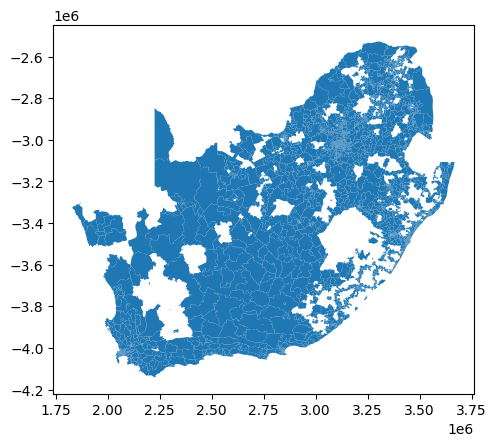

In [104]:
merged.plot()

In [102]:
Features.columns.tolist()

['WardID',
 'Exist',
 'DNExist',
 'People',
 'Potholes',
 'Trash',
 'Cars',
 'Buses',
 'Motorbikes',
 'Trucks',
 'NuPhotos',
 'PotholeRatio',
 'PeopleRatio',
 'TrashRatio',
 'CarRatio',
 'BusRatio',
 'TruckRatio',
 'MotorbikeRatio',
 'NuRoads',
 'RoadRatio',
 'artificial dams (including canals)',
 'artificial flooded mine pits',
 'artificial sewage ponds',
 'bare riverbed material',
 'coastal sand & dunes',
 'commercial',
 'commercial annual crops non-pivot irrigated',
 'commercial annual crops pivot irrigated',
 'commercial annual crops rain-fed / dryland',
 'contiguous & dense plantation forest',
 'contiguous (indigenous) forest',
 'contiguous low forest & thicket',
 'cultivated commercial permanent orchards',
 'cultivated commercial permanent pineapples',
 'cultivated commercial permanent vines',
 'cultivated commercial sugarcane non-pivot',
 'cultivated commercial sugarcane pivot irrigated',
 'cultivated emerging farmer sugarcane non-pivot',
 'dense forest & woodland',
 'dry pans',

In [ ]:
# Features.to_csv('/Users/joseph/SRC/Maters/New/Feb/CSVCreation/Take1/ML Learning Ward Regressions/CSV/Metro.csv', index=False)